# CPSC 330 - Applied Machine Learning 

## Homework 7: Clustering and recommender systems
### Associated lectures: Lectures 14 and 15

**Due date: Monday, November 15, 2021 at 11:59pm**

> Note that this homework is much shorter and simpler than the usual homework assignments because homework 6 is also due on November 15th. 

In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.feature_extraction.text import CountVectorizer

pd.set_option("display.max_colwidth", 0)

<br><br><br><br>

## Instructions 
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md). 

**You may work on this homework in a group and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 3. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br><br><br>

## Exercise 1: Document clustering toy example <a name="1"></a>
<hr>

In lecture 14, we looked at a popular application of clustering: customer segmentation. In this homework, we will work on a toy example of another popular application: [**document clustering**](https://en.wikipedia.org/wiki/Document_clustering). A large amount of unlabeled text data is available out there (e.g., news, recipes, online Q&A), and clustering is a commonly used technique to organize this data in a meaningful way. 

In this exercise, we will create a toy dataset with sentences from Wikipedia articles and cluster these sentences. 

### 1.1 Sample sentences from Wikipedia articles
rubric={points:2}

The code below extracts first sentences of Wikipedia articles on a set of queries. You will need the `wikipedia` package installed in the course environment to run the code below. 

```
conda activate cpsc330
conda install -c conda-forge wikipedia
```

You also need `nltk` library in the course environment. 

```
conda install -c anaconda nltk 
```        

**Your tasks:**

Run the code below and answer the following question. 

1. Given this dataset, how many clusters would you expect a clustering algorithm to identify? How would you manually label these clusters?   

> *Note 2: Feel free to experiment with queries of your choice. But stick to the provided list for the final submission so that it's easier for the TAs when they grade your submission.*


In [2]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
nltk.download("punkt")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Johnn\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [3]:
import wikipedia

queries = [
    "mango_fruit",
    "pastry",
    "Julia language",
    "Python language",
    "hockey",
    "football",
    "supervised learning",
    "unsupervised learning"    
]

wiki_dict = {"wiki query": [], "text": [], "n_words": []}
for i in range(len(queries)):
    sent = sent_tokenize(wikipedia.page(queries[i]).content)[0]
    wiki_dict["text"].append(sent)
    wiki_dict["n_words"].append(len(word_tokenize(sent)))
    wiki_dict["wiki query"].append(queries[i])

wiki_df = pd.DataFrame(wiki_dict)
wiki_df

,wiki query,text,n_words
0,mango_fruit,"A mango is an edible stone fruit produced by the tropical tree Mangifera indica which is believed to have originated from the region between northwestern Myanmar, Bangladesh, and northeastern India.",33
1,pastry,"Pastry is a dough of flour, water and shortening (solid fats, including butter or lard) that may be savoury or sweetened.",26
2,Julia language,"Julia is a high-level, high-performance, dynamic programming language.",11
3,Python language,Python is an interpreted high-level general-purpose programming language.,9
4,hockey,Hockey is a sport in which two teams play against each other by trying to manoeuvre a ball or a puck into the opponent's goal using a hockey stick.,31
5,football,"Football is a family of team sports that involve, to varying degrees, kicking a ball to score a goal.",22
6,supervised learning,Supervised learning (SL) is the machine learning task of learning a function that maps an input to an output based on example input-output pairs.,27
7,unsupervised learning,Unsupervised learning is a type of machine learning in which the algorithm is not provided with any pre-assigned labels or scores for the training data.,26


**We would expect the clustering algorithm to identify 4 different clusters. I would manually identify clusters as food, programming language, sport, and machine learning styles**

<br><br>

### 1.2 `KMeans` with bag-of-words representation 
rubric={points:4}

We have seen that before we pass text to machine learning models, we need to encode it into a numeric representation. So let's encode our toy dataset above (`wiki_df`) to a numeric representation. 

First, let's try our good old friend: bag-of-words representation. The code below creates dense bag-of-words representation of Wikipedia sentences from 1.1 with [`CountVectorizer`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html). 

**Your tasks:**

Run the code below and answer the following questions. 

1. Run `KMeans` clustering on the transformed data (`bow_sents`) with K = the number of clusters you identified in 1.1.  
2. Examine clustering labels assigned by `KMeans`. Is `KMeans` doing a reasonable job in clustering the sentences? 

> You can access cluster label assignments using `labels_` attribute of the clustering object. 

In [4]:
vec = CountVectorizer(stop_words='english')
bow_sents = vec.fit_transform(wiki_df["text"]).todense()
bow_df = pd.DataFrame(
    data=bow_sents, columns=vec.get_feature_names(), index=wiki_df.index
)
bow_df

,algorithm,assigned,ball,bangladesh,based,believed,butter,data,degrees,dough,...,teams,training,tree,tropical,trying,type,unsupervised,using,varying,water
0,0,0,0,1,0,1,0,0,0,0,...,0,0,1,1,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,1,0,0
5,0,0,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
6,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,1,1,0,0,0


In [5]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters = 4, random_state = 1)
kmeans.fit(bow_sents)
bow_df_cl = bow_df.copy()
bow_df_cl["cluster"] =kmeans.predict(bow_df)
kmeans.labels_

array([2, 0, 0, 0, 3, 3, 1, 1])

**I would say Kmeans is doing a decently good job a clustering the sentences (correctly identified 3/4 clusters)**

<br><br>

### 1.3 Sentence embedding representation
rubric={points:6}

Clustering is sensitive to what kind of representation we use for the given data. 
Bag-of-words representation is limited in that it does not take into account word ordering and context. There are other richer representations of text, and we are going to use one such representation in this exercise. 

The code below creates an alternative and a more expressive representation of sentences. We will call it *sentence embedding representation*. We'll use [sentence transformer](https://www.sbert.net/index.html) to extract these representations. At this point it's enough to know that this is an alternative representation of text which usually works better than simple bag-of-words representation. We will talk a bit more about embedding representations next week. You need to install `sentence-transformers` in the course conda environment to run the code below. 

```
conda activate cpsc330
conda install -c conda-forge sentence-transformers
```

**Your tasks:**

Run the code below and answer the following questions. 

1. How many dimensions (features associated with each example) are present in this representation? 
2. Run `KMeans` clustering with sentence embedding representation of text (`emb_sents`) and examine cluster labels. 
3. How well the sentences are clustered together? 

In [6]:
from sentence_transformers import SentenceTransformer

embedder = SentenceTransformer("paraphrase-distilroberta-base-v1")

In [7]:
emb_sents = embedder.encode(wiki_df["text"])
emb_sent_df = pd.DataFrame(emb_sents, index=wiki_df.index)
emb_sent_df

,0,1,2,3,4,5,6,7,8,9,...,758,759,760,761,762,763,764,765,766,767
0,-0.056666,-0.025778,0.248908,-0.052198,-0.046876,0.202116,0.235076,0.322160,-0.023799,0.133034,...,0.239582,-0.022871,0.071445,0.402666,-0.134781,0.177697,-0.123651,0.446757,0.204768,-0.048541
1,-0.062657,0.214339,-0.025160,0.276731,0.401149,0.030865,-0.089944,0.331922,-0.247056,0.175028,...,0.039294,-0.100197,0.201217,0.257111,0.194594,0.280075,0.037366,0.205146,0.044872,-0.078719
2,0.063674,0.287056,0.098705,0.048766,0.562877,-0.015978,-0.129418,0.098363,0.249305,0.269618,...,0.483838,-0.017338,0.194521,0.185484,0.536235,0.137246,0.368983,-0.028611,-0.017652,-0.192852
3,0.112806,-0.137214,0.082946,-0.066925,0.558055,0.197494,-0.034394,0.421297,0.105453,0.280035,...,0.464874,0.291358,-0.028042,0.120064,0.021188,0.300265,0.323037,0.072128,0.047298,-0.076177
4,-0.027003,-0.244208,-0.090704,0.037250,0.029517,-0.441170,0.205250,0.373760,-0.046666,-0.006260,...,0.479729,-0.121558,0.002595,-0.147080,-0.277787,0.082878,-0.182319,0.786005,0.235606,-0.125455
5,-0.071756,0.133156,-0.071761,0.306060,0.358961,-0.061443,0.167584,0.364614,0.323541,0.141398,...,0.404115,0.000236,0.177493,0.016162,0.232335,0.260556,0.168149,0.483963,0.121122,0.196881
6,0.056006,-0.111174,-0.041483,0.279775,0.758024,0.181266,0.128420,0.323363,0.297055,0.154679,...,-0.007967,-0.061345,0.352495,0.011700,-0.358587,-0.052314,0.370847,-0.276011,0.105793,0.175194
7,0.040102,-0.104918,-0.181901,0.099643,0.746790,0.334654,0.106366,0.238596,0.142745,0.110568,...,0.113404,0.065607,-0.014091,-0.047726,-0.410689,0.133482,0.388844,-0.313182,0.013006,-0.074869


In [8]:
kmeans = KMeans(n_clusters = 4, random_state = 1)
kmeans.fit(emb_sents)
emb_df_cl = emb_sent_df.copy()
emb_df_cl["cluster"] =kmeans.predict(emb_sent_df)
kmeans.labels_

array([3, 3, 1, 1, 0, 0, 2, 2])

**1. There are 768 total dimensions in this representation.**
\
**3.The sentences are well clustered together with similar sentences correctly matching to the same cluster.**

<br><br>

### 1.4 DBSCAN with cosine distance  
rubric={points:8}

Let's try `DBSCAN` on our toy dataset. K-Means is kind of bound to the Euclidean distance because it is based on the notion of means. With `DBSCAN` we can try different distance metrics. In the context of text (sparse data), [cosine similarities](https://scikit-learn.org/stable/modules/metrics.html#cosine-similarity) or cosine distances tend to work better. Given vectors $u$ and $v$, the **cosine distance** between the vectors is defined as: 

$$distance_{cosine}(u,v) = 1 - (\frac{u \cdot v}{\left\lVert u\right\rVert_2 \left\lVert v\right\rVert_2})$$

In this exercise, you'll use DBSCAN with cosine distances. 

**Your tasks**

1. Use DBSCAN to cluster our toy data using sentence embedding representation (`emb_sents`) and `metric='cosine'`. 
2. Briefly comment on the number of clusters identified and the cluster assignment given by the algorithm.

> *Note: You will also have to set appropriate values for the hyperparamters `eps` and `min_samples` to get meaningful clusters, as default values for these hyperparameters won't work on this toy dataset. In order to set appropriate value for `eps`, you may want to examine the distances given by [sklearn's `cosine_distance`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_distances.html).*

In [9]:
from sklearn.cluster import DBSCAN
from sklearn.metrics.pairwise import cosine_distances
# print(cosine_distances(emb_sents))

dbscan = DBSCAN(eps=0.6, min_samples=2, metric='cosine')
dbscan.fit(emb_sents)
db_scan_emb_cl = emb_sent_df.copy()
db_scan_emb_cl["cluster"] = dbscan.fit_predict(emb_sents)
dbscan.labels_

array([-1, -1,  0,  0,  1,  1,  2,  2], dtype=int64)

<br><br>

### 1.5 Visualizing clusters 
rubric={points:5}

One thing we could do with unlabeled data is visualizing it. That said, our data is high dimensional (each example is represented with 768 dimensions) and high-dimensional data is hard to visualize. One way to visualize high-dimensional data is applying dimensionality reduction to get the most important (2 or 3) components of the dataset and visualizing this low-dimensional data. 

Given data as a `numpy` array and cluster assignments, the `plot_pca_clusters` function below transforms the given data by applying dimensionality reduction and plots the transformed data into corresponding clusters. 

> *Note: At this point we are using this function only for visualization and you are not expected to understand the PCA part. Feel free to modify the function as you see fit.*

**Your tasks:**

1. Call the function `plot_pca_clusters` to visualize the clusters created by the three models above:
    - KMeans with bag-of-words representation 
    - KMeans with sentence embedding representation 
    - DBSCAN with sentence embedding representation 

In [10]:
from sklearn.decomposition import PCA # Obtain the principal components

def plot_pca_clusters(
    data,
    cluster_labels,
    raw_sents=wiki_df["text"],
    show_labels=False,
    size=100,
    title="PCA visualization",
):
    """
    Carry out dimensionality reduction using PCA and plot 2-dimensional clusters.

    Parameters
    -----------
    data : numpy array
        data as a numpy array
    cluster_labels : list
        cluster labels for each row in the dataset
    raw_sents : list
        the original raw sentences for labeling datapoints
    show_labels : boolean
        whether you want to show labels for points or not (default: False)
    size : int
        size of points in the scatterplot
    title : str
        title for the visualization plot

    Returns
    -----------
    None. Shows the clusters.
    """

    pca = PCA(n_components=2)
    principal_comp = pca.fit_transform(data)
    pca_df = pd.DataFrame(data=principal_comp, columns=["pca1", "pca2"])
    pca_df["cluster"] = cluster_labels

    plt.figure(figsize=(10, 7))
    plt.title(title)
    ax = sns.scatterplot(
        x="pca1", y="pca2", hue="cluster", data=pca_df, palette="tab10", s=size
    )

    x = pca_df["pca1"].tolist()
    y = pca_df["pca2"].tolist()
    if show_labels:
        for i, txt in enumerate(raw_sents):
            plt.annotate(" ".join(txt.split()[:10]), (x[i], y[i]))
        ax.legend(loc="upper right")

    plt.show()

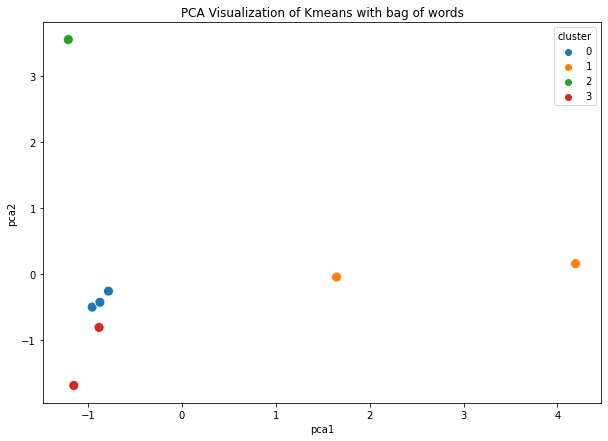

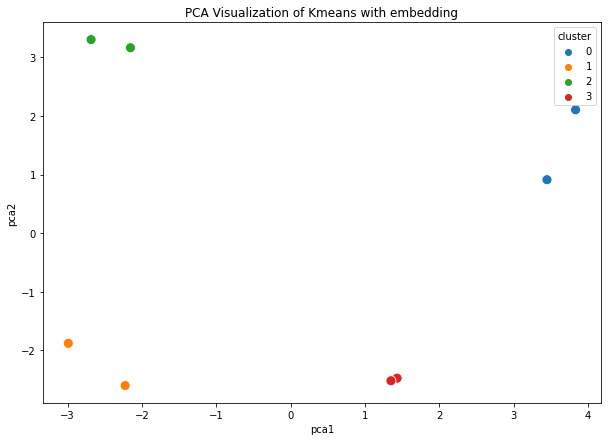

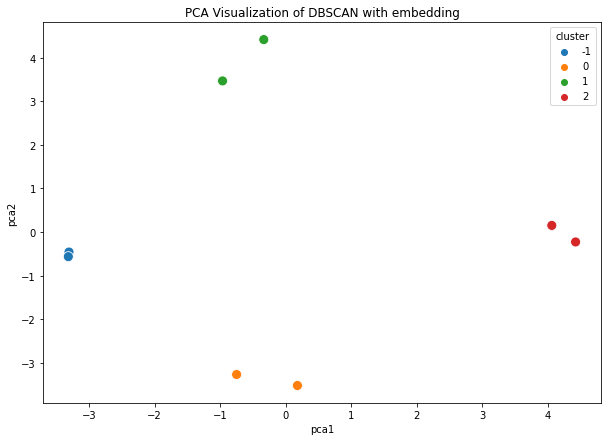

In [11]:
plot_pca_clusters(bow_df, bow_df_cl["cluster"], title = "PCA Visualization of Kmeans with bag of words")
plot_pca_clusters(emb_sent_df, emb_df_cl["cluster"], title = "PCA Visualization of Kmeans with embedding")
plot_pca_clusters(db_scan_emb_cl, db_scan_emb_cl["cluster"], title = "PCA Visualization of DBSCAN with embedding")

<br><br><br><br>

## Exercise 2: Movie recommendations
<hr>

Let's build simple movie recommendation systems using the [MovieLens dataset](https://www.kaggle.com/prajitdatta/movielens-100k-dataset/data). The original source of the data is [here](https://grouplens.org/datasets/movielens/), and the structure of the data is described in the [README](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html) that comes with it. The code below reads the data as a CSV assuming that it's under `data/ml-100k/` directory under your lab folder. 

In [12]:
r_cols = ["user_id", "movie_id", "rating", "timestamp"]
ratings = pd.read_csv(
    os.path.join("data", "ml-100k", "u.data"),
    sep="\t",
    names=r_cols,
    encoding="latin-1",
)
ratings.head()

,user_id,movie_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [13]:
# We'll be using these keys later in the starter code
user_key = "user_id"
item_key = "movie_id"

### 2.1 Terminology
rubric={points:3}

Here is some notation we will be using in this homework. 

**Constants**:

 - $N$: the number of users, indexed by $n$
 - $M$: the number of movies, indexed by $m$
 - $\mathcal{R}$: the set of indices $(n,m)$ where we have ratings in the utility matrix $Y$
    - Thus $|\mathcal{R}|$ is the total number of ratings
 
**The data**:

 - $Y$: the utility matrix containing ratings, with a lot of missing entries
 - `train_mat` and `valid_mat`: Utility matrices for train and validation sets, respectively
 
    
**Your tasks:**    

1. What are the values of $N$ and $M$ in movie ratings data?  
2. What would be the shape of the dense utility matrix $Y$? 
3. What would be the fraction of non missing ratings in the utility matrix $Y$? 

In [14]:
N = ratings[user_key].nunique()
M = ratings[item_key].nunique()
Y = N*M
print("Number of users(N):", N)
print("Number of movies(M):", M)
print("Shape of dense utility matrix (Y):", Y)
print("Fraction of non-missing ratings:", (ratings.shape[0]/Y))

Number of users(N): 943
Number of movies(M): 1682
Shape of dense utility matrix (Y): 1586126
Fraction of non-missing ratings: 0.06304669364224531


<br><br>

### 2.2 Splitting the data
rubric={points:5}

**Your tasks:**

1. Split the ratings data with `test_size=0.2` and `random_state=42`. 

In [15]:
#From lecture 15
from sklearn.model_selection import train_test_split

X = ratings.copy()
y = ratings[user_key]
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<br><br>

### 2.3 Utility matrix 
rubric={points:10}

**Your tasks**
1. Create utility matrices for train and validation sets (similar to how we did in the class). 
2. Briefly explain the difference between the train and validation utility matrices. 

> You may use the code from lecture notes with appropriate attributions.  

> You won't do it in real life but since our dataset is not that big, create a dense utility matrix in this assignment. You are welcome to try sparse matrix but then you may have to change some started code provided in the later exercises.  

In [16]:
user_mapper = dict(zip(np.unique(ratings[user_key]), list(range(N))))
item_mapper = dict(zip(np.unique(ratings[item_key]), list(range(M))))
user_inverse_mapper = dict(zip(list(range(N)), np.unique(ratings[user_key])))
item_inverse_mapper = dict(zip(list(range(M)), np.unique(ratings[item_key])))

#From Lecture 15
def create_Y_from_ratings(data, N, M):
    Y = np.zeros((N, M))
    Y.fill(np.nan)
    for index, val in data.iterrows():
        n = user_mapper[val[user_key]]
        m = item_mapper[val[item_key]]
        Y[n, m] = val["rating"]

    return Y

In [17]:
train_mat = create_Y_from_ratings(X_train, N, M)
valid_mat = create_Y_from_ratings(X_valid, N, M)

**Only the ratings from the training set are found in the training matrix. And only the ratings from the validation set are found in the validation matrix. We use the validation matrix to test power of the model**

<br><br>

### 2.4 Evaluation and baseline
rubric={points:4}

To compare different models you build in this homework, let's write a couple of functions for evaluation. 
- The `error` function returns RMSE.
- The `evaluate` function prints the train and validation RMSEs. 

**Your task:**

1. Briefly explain what exactly we are comparing to evaluate recommender systems. 
2. Implement the global average baseline, where you predict everything as the global average rating. What's the RMSE of the global average baseline?

In [18]:
def error(Y1, Y2):
    """
    Returns the root mean squared error (RMSE).
    """
    return np.sqrt(np.nanmean((Y1 - Y2) ** 2))


def evaluate(pred_Y, train_mat, valid_mat, model_name="Global average"):
    print("%s train RMSE: %0.2f" % (model_name, error(pred_Y, train_mat)))
    print("%s valid RMSE: %0.2f" % (model_name, error(pred_Y, valid_mat)))
    

In [19]:
#From lecture 15 (global average baseline)
avg = np.nanmean(train_mat)
pred_g = np.zeros(train_mat.shape) + avg
pd.DataFrame(pred_g).head()

,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,...,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262
1,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,...,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262
2,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,...,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262
3,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,...,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262
4,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,...,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262,3.531262


In [20]:
evaluate(pred_g, train_mat, valid_mat, model_name="Global average")
print("The global average RMSE is:", pred_g[0][0])

Global average train RMSE: 1.13
Global average valid RMSE: 1.12
The global average RMSE is: 3.5312625


**1. We are comparing the predicted score and the actual score of ratings (measured in RMSE).**
\
**2. The global average RMSE is 3.531262**

<br><br>

### (Optional) 2.5 $k$-nearest neighbours imputation
rubric={points:1}

**Your tasks:**

Try [KNNImputer](https://scikit-learn.org/stable/modules/generated/sklearn.impute.KNNImputer.html) to fill in the missing entries. Discuss your observations. 

In [21]:
# from sklearn.impute import KNNImputer

# imputer = KNNImputer(n_neighbors=10)
# train_mat_imp = imputer.fit_transform(train_mat, y = (943, 1682))
# pd.DataFrame(train_mat_imp), pd.DataFrame(train_mat)

In [22]:
# evaluate(train_mat_imp, train_mat, valid_mat, model_name="KNN imputer")

<br><br>

### 2.6 Use collaborative filtering with the `surprise` package
rubric={points:6}

Use the [`surprise`](https://surprise.readthedocs.io/en/stable/) package which has implementation of SVD algorithm for collaborative filtering. You can install it as follows in your conda environment. 

```
>> conda activate cpsc330
>> conda install -c conda-forge scikit-surprise
or 
>> pip install scikit-surprise
```

**Your tasks:**

1. Carry out cross-validation using SVD algorithm in the package, similar to how we did it in the lecture on Jester dataset. Report mean RMSE and compare it with global baseline. 

In [23]:
import surprise
from surprise import SVD, Dataset, Reader, accuracy

#Code from lecture 15

ratings_df = ratings.drop(columns = "timestamp")
reader = Reader()
data = Dataset.load_from_df(ratings_df, reader)

trainset, validset = surprise.model_selection.train_test_split(
    data, test_size=0.2, random_state=42
)

k = 10
algo = SVD(n_factors=k, random_state=42)
algo.fit(trainset)
svd_preds = algo.test(validset)
accuracy.rmse(svd_preds, verbose=True)

RMSE: 0.9328


0.932839700199596

In [24]:
from surprise.model_selection import cross_validate
#from lecture 15

results = cross_validate(algo, data, measures=["RMSE", "MAE"], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9315  0.9391  0.9436  0.9321  0.9379  0.9368  0.0045  
MAE (testset)     0.7367  0.7393  0.7434  0.7382  0.7421  0.7399  0.0025  
Fit time          2.44    2.71    3.07    2.80    2.75    2.76    0.20    
Test time         0.16    0.22    0.28    0.19    0.26    0.22    0.04    


In [25]:
pd.DataFrame(results).mean()

test_rmse    0.936833
test_mae     0.739950
fit_time     2.755230
test_time    0.220611
dtype: float64

**The SVD algorithm produced a mean RMSE of 0.936 which is lower than the global test RMSE of 1.12.**

<br><br><br><br>

## Exercise 3: Short answer questions
<hr>

rubric={points:5}

Answer the following short-answer questions: 

1. What's the main difference between unsupervised and supervised learning?
2. When choosing $k$ in K-Means, why not just choose the $k$ that leads to the smallest inertia (sum of squared distances within clusters)?
3. You decide to use clustering for _outlier detection_; that is, to detect instances that are very atypical compared to all the rest. How might you do this with $k$-means?
4. You decide to use clustering for _outlier detection_; that is, to detect instances that are very atypical compared to all the rest. How might you do this with DBSCAN?
5. How might you apply clustering to recommendation systems? 

**1. The main difference between supervised and unsupervised learning is that the training data have no corresponding targets in unsupervised learning whereas there are targets in supervised learning. Additionally unsupervised learning is used to group similarities in the data together.**
\
**2. We don't choose the k that leads to the smallest intertia because that would lead to choosing k equals the number of data points which will lead to inertia of 0. We choose the K at the elbow point because that is possibly the k which groups the data point together the best (additional increase in K has little change relatively on inertia)**
\
**3. Optimize for k using the elbow/silhouette method. Set a threshold distance between the point and is corresponding distance. If the distance between the cluster center and the point exceeds the threshold, it is considered an outlier.**
\
**4. Modify the eps value (used as a threshold for grouping points together in a cluster.**
\
**5. Clustering can be used by recommendation systems by grouping similar things together. For example, if a person likes a certain movie and wants to seek out a similar movie, we can use a clustering algorithm to find similar movies to the one that the user selects.**

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 